<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/master/03-Deep-Learning/notebooks/Tarea-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

print('GPU presente en: {}'.format(tf.test.gpu_device_name()))

GPU presente en: /device:GPU:0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

# Tarea 2: X-rays
**Andrea Benítez Pineda**































Este conjunto de entrenamiento consta de 5886 imágenes de rayos X de torax divididas en dos clases: Pneumonia y Normal.

Estas imágenes de radiografía de tórax son de pacientes pediátricos de uno a cinco años del Centro Médico de Mujeres y Niños de Guangzhou, Guangzhou. Todas las radiografías de tórax se realizaron como parte de la atención clínica rutinaria de los pacientes.

Para el análisis de las imágenes, se sometieron inicialmente a un control de calidad mediante la eliminación de todas las exploraciones de baja calidad o ilegibles. A continuación, los diagnósticos de las imágenes fueron calificados por dos médicos expertos antes de ser autorizados para el entrenamiento del sistema de IA. Para tener en cuenta cualquier error de clasificación, el conjunto de evaluación también fue revisado por un tercer experto.

Este conjunto de datos se puede encontrar en [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).

La copia con la que trabajaremos se puede bajar de Google Drive: https://drive.google.com/file/d/1jbkvQB4L5y3UKkPurNp6nJonSoYbcYbI/view?usp=sharing

In [3]:
!pip install -q gdown

In [4]:
!gdown 1jbkvQB4L5y3UKkPurNp6nJonSoYbcYbI

Downloading...
From: https://drive.google.com/uc?id=1jbkvQB4L5y3UKkPurNp6nJonSoYbcYbI
To: /content/x-rays.zip
100% 1.24G/1.24G [00:09<00:00, 128MB/s]


Extraemos los archivos

In [5]:
from zipfile import ZipFile

fname = '/content/x-rays.zip'

with ZipFile(fname, 'r') as myzip:
    myzip.extractall()
    print('Listo')

Listo


Definimos las rutas de los archivos

In [6]:
train_dir = 'x-rays/train'
validation_dir = 'x-rays/val'
test_dir = 'x-rays/test'

Graficamos algunas instancias de cada clase

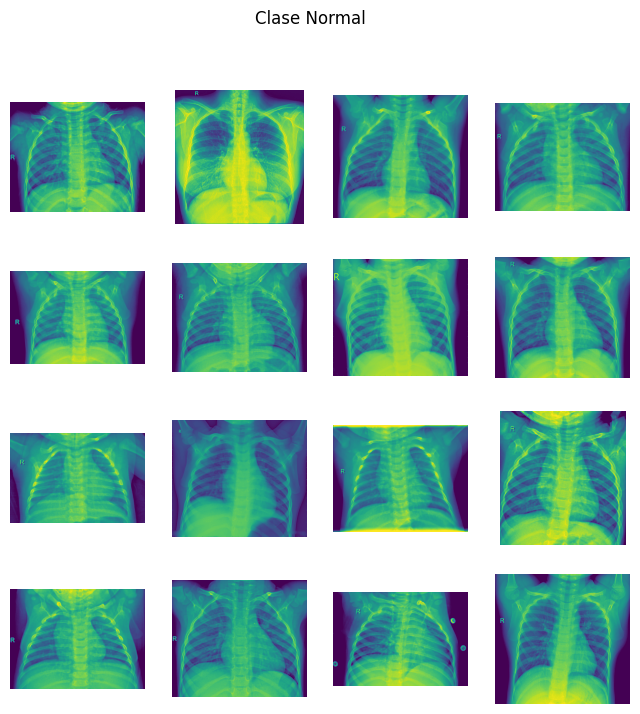

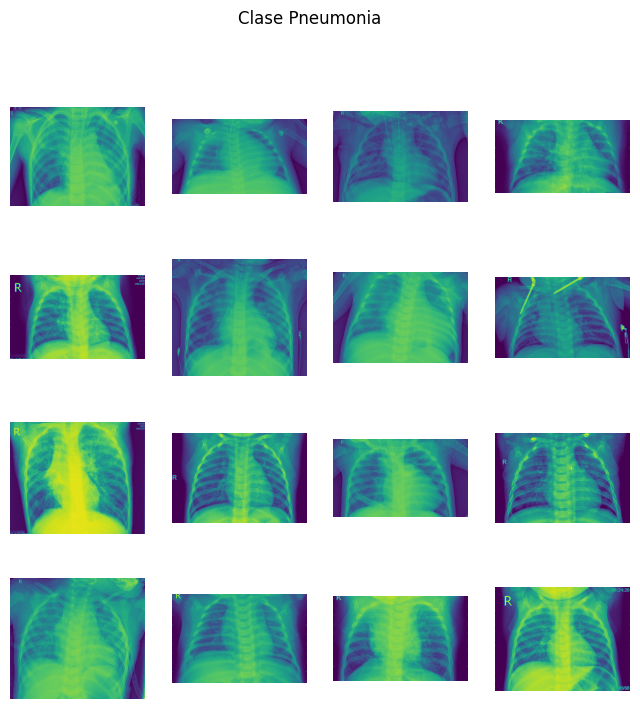

In [7]:
import pathlib
import PIL
import matplotlib.pyplot as plt

train_path = pathlib.Path(train_dir)

normal_vis = list(train_path.glob("NORMAL/*.jpeg"))

plt.figure(figsize = (8,8))
plt.suptitle("Clase Normal")
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = PIL.Image.open(str(normal_vis[i]))
    plt.imshow(img)
    plt.axis(False)
plt.show()

pneumonia_vis = list(train_path.glob("PNEUMONIA/*.jpeg"))

plt.figure(figsize = (8,8))
plt.suptitle("Clase Pneumonia")
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = PIL.Image.open(str(pneumonia_vis[i]))
    plt.imshow(img)
    plt.axis(False)
plt.show()

In [8]:
import os, shutil

print('Para entrenamiento:')
train_normal = os.path.join(train_dir,'NORMAL')
print(f"{len(os.listdir(train_normal))} Normal.")
train_pneumonia = os.path.join(train_dir,'PNEUMONIA')
print(f"{len(os.listdir(train_pneumonia))} Pneumonia.")

print('\nPara validación:')
validation_normal = os.path.join(validation_dir,'NORMAL')
print(f"{len(os.listdir(validation_normal))} Normal.")
validation_pneumonia = os.path.join(validation_dir,'PNEUMONIA')
print(f"{len(os.listdir(validation_pneumonia))} Pneumonia.")

print('\nPara prueba:')
test_normal = os.path.join(test_dir,'NORMAL')
print(f"{len(os.listdir(test_normal))} Normal.")
test_pneumonia = os.path.join(test_dir,'PNEUMONIA')
print(f"{len(os.listdir(test_pneumonia))} Pneumonia.")

Para entrenamiento:
1341 Normal.
3875 Pneumonia.

Para validación:
8 Normal.
8 Pneumonia.

Para prueba:
234 Normal.
390 Pneumonia.


In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256,256),
        batch_size=32, # <-------- Este número lo usarás en la siguiente celda
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(256,256),
        batch_size=8, # <-------- Este número lo usarás en la siguiente celda
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256,256),
        batch_size=16,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


⭕ ¿Cuántos lotes hay que pasar para recorrer todo el conjunto de entrenamiento por cada época? ¿cuántos para recorrer todo el conjunto de validación?

In [10]:
steps_per_epoch = 5216/32# calcula este número= total_samples/batch_size
steps_per_epoch = int(steps_per_epoch)
validation_steps =16/8 # calcula este número
validation_steps = int(validation_steps)

print(f"Número de lotes para recorrer el conjunto de entrenamiento: {steps_per_epoch}")
print(f"Número de lotes para recorrer el conjunto de validación: {validation_steps}")

Número de lotes para recorrer el conjunto de entrenamiento: 163
Número de lotes para recorrer el conjunto de validación: 2


In [11]:
for data_batch, labels_batch in train_generator:
    print('Dimensiones del batch de imágenes:', data_batch.shape)
    print('Dimensiones del batch de las etiquetas:', labels_batch.shape)
    break

Dimensiones del batch de imágenes: (32, 256, 256, 3)
Dimensiones del batch de las etiquetas: (32,)


##  El modelo

⭕ Define un módelo de red neuronal CNN para la tarea de clasificación binaria de este conjunto de datos. Puedes usar dropout, el número de capas, épocas y activaciones que consideres necesario.

Al final, reporta las métrica Accuracy.

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu',
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='selu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [42]:
model.compile(optimizer='RMSProp',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 516128)            0         
                                                                 
 dropout_10 (Dropout)        (None, 516128)            0         
                                                                 
 dense_10 (Dense)            (None, 512)               264258048 
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                      

⭕ Define un callback `EarlyStopping` llamado `e_stopping` para detener el entrenamiento si comienza el overfitting. Puedes experimentar con el hiper-parámetro `patience`

In [44]:
e_stopping =EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)


Realiza el entrenamiento del modelo

In [45]:
num_epocas = 100

history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=num_epocas,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[e_stopping])

Epoch 1/100
163/163 [==============================] - 69s 411ms/step - loss: 1.9210 - accuracy: 0.7665 - val_loss: 0.2356 - val_accuracy: 0.8750
Epoch 2/100
163/163 [==============================] - 65s 399ms/step - loss: 0.2275 - accuracy: 0.9206 - val_loss: 0.0403 - val_accuracy: 1.0000
Epoch 3/100
163/163 [==============================] - 65s 398ms/step - loss: 0.2515 - accuracy: 0.9410 - val_loss: 1.6073 - val_accuracy: 0.5000
Epoch 4/100
163/163 [==============================] - 65s 400ms/step - loss: 0.2323 - accuracy: 0.9475 - val_loss: 0.0593 - val_accuracy: 1.0000
Epoch 5/100
163/163 [==============================] - 63s 389ms/step - loss: 0.1175 - accuracy: 0.9645 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 6/100
163/163 [==============================] - 63s 387ms/step - loss: 0.0909 - accuracy: 0.9693 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 7/100
163/163 [==============================] - 66s 406ms/step - loss: 0.1604 - accuracy: 0.9628 - val_loss: 0.0112 -

Evalua el desempeño de tu modelo usando el conjunto de entrenamiento.

In [46]:
score = model.evaluate(test_generator)
print ('Test loss:', round(score[0], 3))
print ('Test accuracy:', round(score[1]*100, 2))

39/39 [==============================] - 6s 145ms/step - loss: 1.0519 - accuracy: 0.7468
Test loss: 1.052
Test accuracy: 74.68


⭕ Grafica las curvas de entrenamiento de loss y accuracy

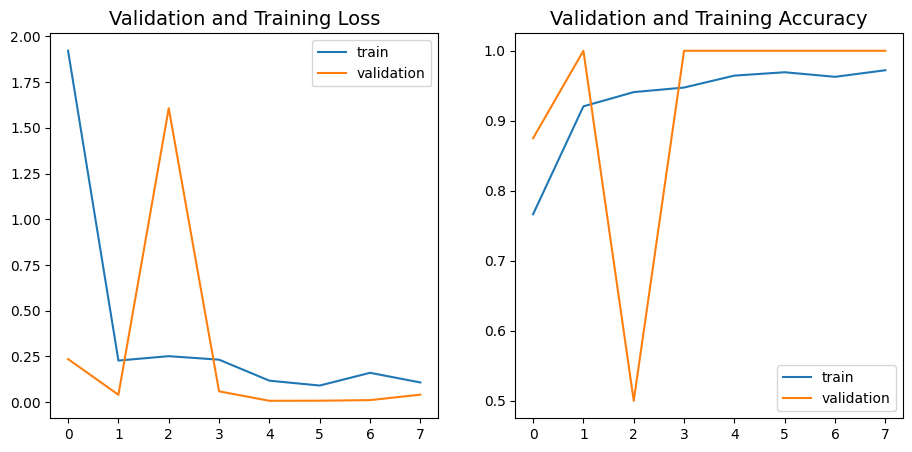

In [47]:
# ---- graficamos la función de perdida ----
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.title("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
# ---- graficamos la métrica de rendimiento ----
plt.subplot(1,2,2)
plt.title("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()